In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
farocat = pd.read_csv('J_ApJ_702_1230_catalog.dat.gz.csv', delimiter = ',')

| Header Acronym | Measurement | Units |
|:-|:-|:-|
|RA|Right Ascension|(hours, minutes, seconds)|
|DE|Declination|(degree, arcminutes, arcseconds)|
|GLON/LAT|Glactic Longitude/Latitude|(degrees)|
|Si|NVSS integrated Stokes I flux density|(milliJansky)|
|Pk|Average peak polarized intensity|(milliJansky)|
|m|ratio of Pk to Si|(%)|
|RM|Rotation Measure|(rad/m$^2$)|

e_ is the 1$\sigma$ error of each measurement

In [3]:
farocat.head(5)

RAh  RAm    RAs  e_RAs  DEd  DEm   DEs  eDEs      GLON     GLAT     Si  \
0    0    0   2.87   0.03    9   57   6.6   0.6  102.6200 -50.8820  301.4   
1    0    0   8.22   0.12   75   40  11.9   0.6  119.6979  13.1213  139.3   
2    0    0   9.21   0.04   25   26  20.1   0.6  108.5905 -36.0006   59.5   
3    0    0  10.10   0.04   30   55  59.5   0.6  110.1511 -30.6630   88.2   
4    0    0  12.20   0.04   29   11  14.4   0.6  109.6856 -32.3632   83.4   

   e_Si     Pk  e_Pk     m   e_m    RM  e_RM  
0  10.6  10.72  0.28  3.85  0.10  -7.7   4.9  
1   4.2   6.97  0.28  5.08  0.20  15.4   9.0  
2   2.2   4.02  0.27  7.82  0.53 -59.0  14.7  
3   2.7   5.55  0.29  6.51  0.34 -37.9  11.0  
4   2.9   3.70  0.27  5.25  0.38 -87.0  15.1

In [4]:
gal = SkyCoord(farocat['GLON'], farocat['GLAT'], frame='galactic', unit=u.deg)

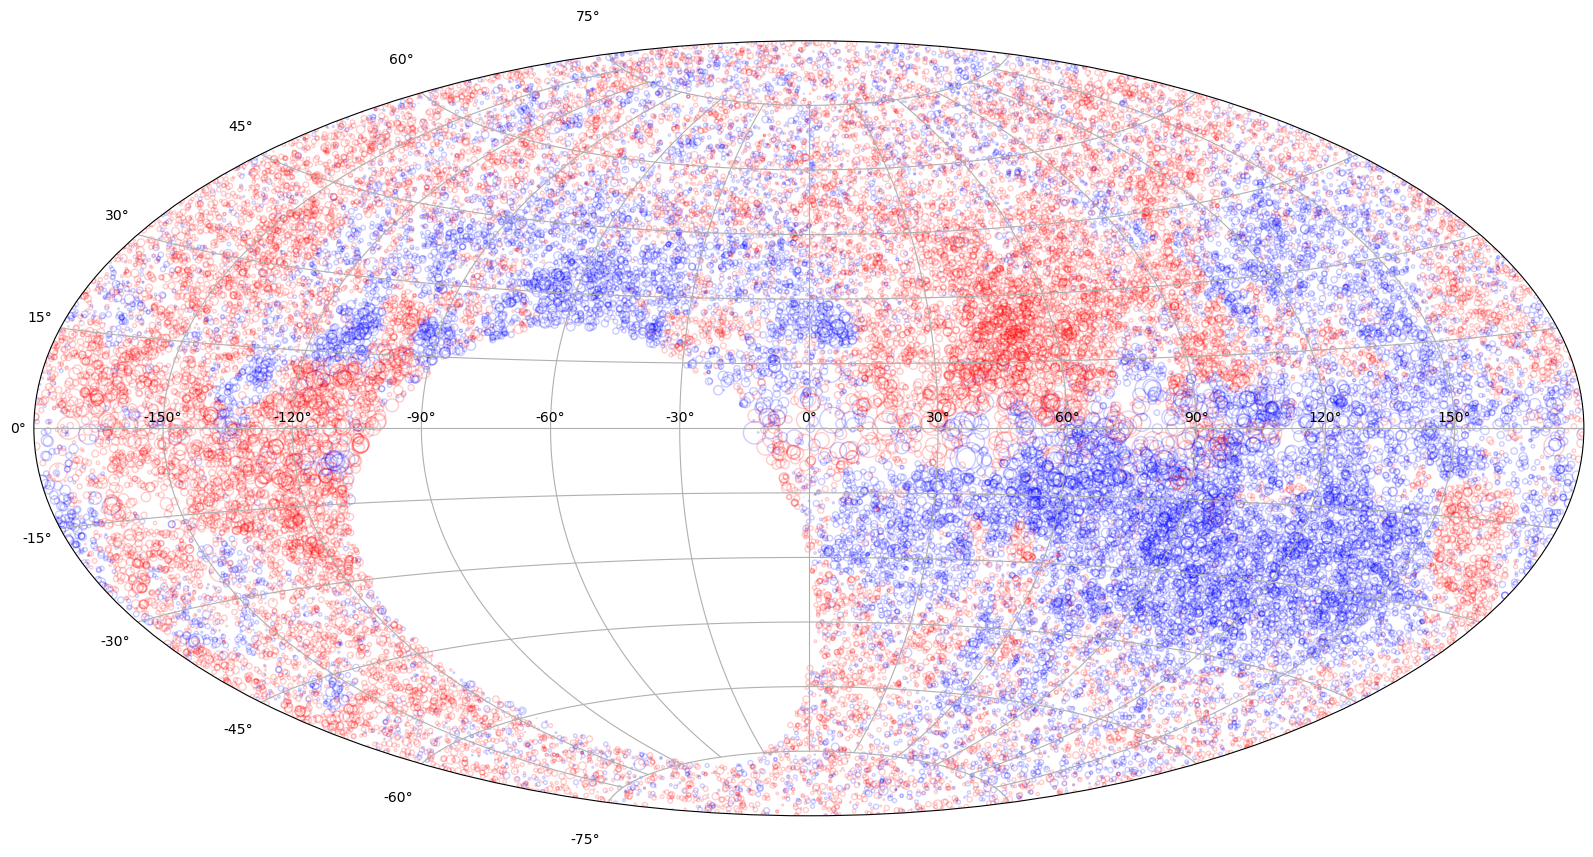

In [5]:
plt.figure(figsize=(20,20))
plt.subplot(111, projection='aitoff')
plt.grid(True)
colour = ['r' if rm>0 else 'b' for rm in farocat['RM']]
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian,
            facecolors = 'none',
            edgecolors = colour,
            s = np.abs(farocat['RM']/2),
            alpha = 0.2)


<AxesSubplot:>

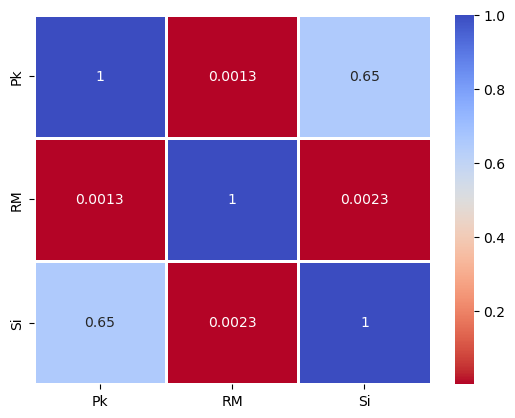

In [6]:
corr = farocat[['Pk','RM','Si']].corr()
sb.heatmap(corr, annot=True, linewidth=1, linecolor='w', cmap='coolwarm_r')

# Linear Regression (maybe)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

Text(0.5, 1.0, 'NVSS Integrated Stokes I Flux')

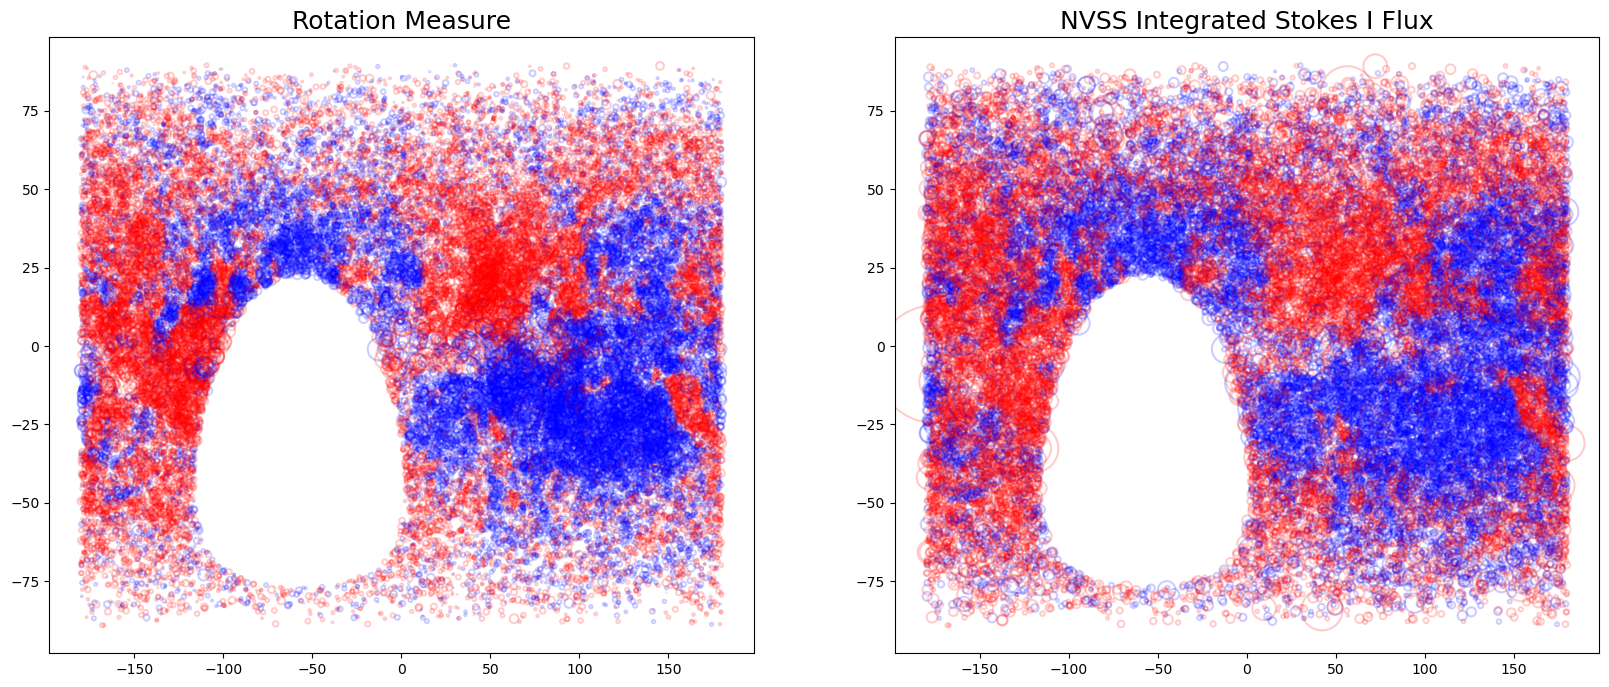

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
sb.set_context('talk')
RMcolour = ['r' if rm>0 else 'b' for rm in farocat['RM']]
ax[0].scatter(x = farocat['GLON'], y = farocat['GLAT'],
              facecolors = 'none',
              edgecolors = colour,
              s = np.abs(farocat['RM']/2),
              alpha = 0.2)
ax[0].set_title('Rotation Measure')


Sicolour = ['r' if si>0 else 'b' for si in farocat['Si']]
ax[1].scatter(x = farocat['GLON'], y = farocat['GLAT'],
              facecolors = 'none',
              edgecolors = colour,
              s = np.abs(farocat['Si'])/10,
              alpha = 0.2)
ax[1].set_title('NVSS Integrated Stokes I Flux')

Text(0.5, 1.0, 'Rotation Measure vs NVSS Data')

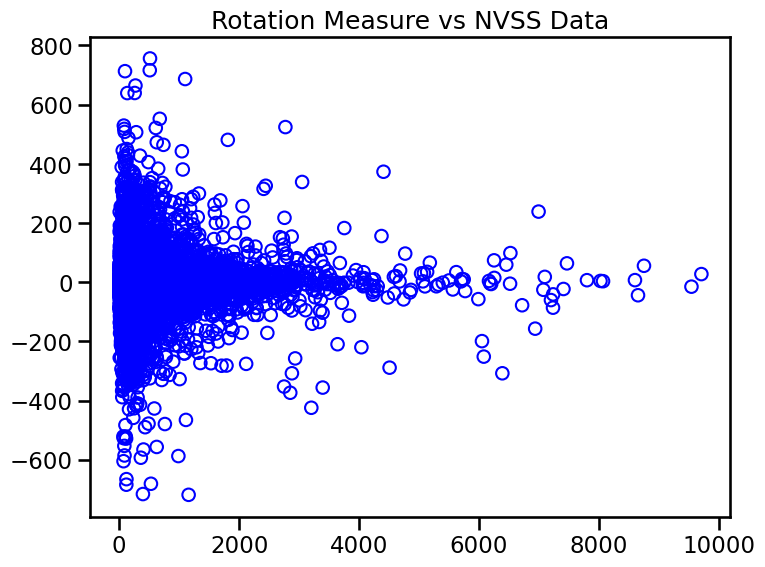

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sb.set_context('talk')
linearitytest = farocat[['Si', 'RM']][farocat['Si']<10000]
ax.scatter(x = linearitytest['Si'], y = linearitytest['RM'],
           facecolor = 'none',
           edgecolor = 'b')
ax.set_title('Rotation Measure vs NVSS Data')

# ANN

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [11]:
y = farocat['RM']
xpre = farocat[['GLON', 'GLAT', 'Si', 'Pk', 'm']]

In [12]:
xtrainpre, xmidpre, ytrain, ymid = train_test_split(xpre, y, test_size = .3)

In [13]:
xvalidpre, xtestpre, yvalid, ytest = train_test_split(xmidpre, ymid, test_size = .5)

In [14]:
xtestpre

GLON     GLAT      Si     Pk      m
7549  -168.5734 -27.4213  1046.2   7.08   0.69
25855   90.9364  49.2835   138.2   4.92   3.76
29053   47.0751  24.3361   148.1   4.58   3.35
29867   69.0888  22.3037   148.3   3.91   2.70
22504  -45.3138  34.7529   271.3  42.98  31.93
...         ...      ...     ...    ...    ...
30318   90.3244  23.6111   113.9   5.37   5.88
5051   153.9919 -25.4023    66.6   3.39   6.36
33539   44.3467 -38.3928    81.2  10.24  17.79
4085   165.2742 -53.4088   362.9  13.30   3.89
25401    0.5416  47.2071   181.4   8.59   5.09

[5632 rows x 5 columns]

In [15]:
scal = StandardScaler()

scaledtraindata = pd.DataFrame(scal.fit_transform(xtrainpre[['Si', 'Pk', 'm']]), columns = [['Si', 'Pk', 'm']])
scaledvaliddata = pd.DataFrame(scal.transform(xvalidpre[['Si', 'Pk', 'm']]), columns = [['Si', 'Pk', 'm']])
scaledtestdata = pd.DataFrame(scal.transform(xtestpre[['Si', 'Pk', 'm']]), columns = [['Si', 'Pk', 'm']])

In [16]:
xtrain = xtrainpre[['GLON', 'GLAT']].reset_index(drop=True)

xtrain[['Si', 'Pk', 'm']] = scaledtraindata[['Si', 'Pk', 'm']].reset_index(drop=True)

In [17]:
xvalid = xvalidpre[['GLON', 'GLAT']].reset_index(drop=True)

xvalid[['Si', 'Pk', 'm']] = scaledvaliddata[['Si', 'Pk', 'm']].reset_index(drop=True)

In [18]:
xtest = xtestpre[['GLON', 'GLAT']].reset_index(drop=True)

xtest[['Si', 'Pk', 'm']] = scaledtestdata[['Si', 'Pk', 'm']].reset_index(drop=True)

In [19]:
ytrain = ytrain.reset_index(drop = True)
yvalid = yvalid.reset_index(drop = True)
ytest = ytest.reset_index(drop = True)

In [20]:
model = Sequential()

model.add(Dense(5, activation = 'linear',))
model.add(Dropout(0.5))

model.add(Dense(4, activation = 'tanh'))
model.add(Dropout(0.5))

model.add(Dense(4, activation = 'linear'))
model.add(Dropout(0.5))

model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


early_stop = EarlyStopping(monitor = 'val_loss',
                           mode = 'min',
                           verbose = 1,
                           # restore_best_weights = True,
                           patience = 25,
                           )

In [21]:
model.fit(x = xtrain, y = ytrain,
          epochs = 1000,
          # batch_size = 1000,
          validation_data = (xvalid, yvalid),
          callbacks = early_stop)

Epoch 1/1000
822/822 [==============================] - 1s 905us/step - loss: 3451.5300 - val_loss: 3599.8110
Epoch 2/1000
822/822 [==============================] - 1s 704us/step - loss: 3422.9333 - val_loss: 3576.1077
Epoch 3/1000
822/822 [==============================] - 1s 706us/step - loss: 3406.3735 - val_loss: 3548.0728
Epoch 4/1000
822/822 [==============================] - 1s 665us/step - loss: 3401.2087 - val_loss: 3528.3860
Epoch 5/1000
822/822 [==============================] - 1s 667us/step - loss: 3395.4639 - val_loss: 3516.8604
Epoch 6/1000
822/822 [==============================] - 1s 661us/step - loss: 3379.0198 - val_loss: 3495.3877
Epoch 7/1000
822/822 [==============================] - 1s 749us/step - loss: 3381.3325 - val_loss: 3489.7468
Epoch 8/1000
822/822 [==============================] - 1s 672us/step - loss: 3353.5859 - val_loss: 3461.8311
Epoch 9/1000
822/822 [==============================] - 1s 648us/step - loss: 3355.3140 - val_loss: 3454.5129
Epoch 10/1

In [22]:
pred = model.predict(xtest)

176/176 [==============================] - 0s 416us/step


In [23]:
print(np.sqrt(mean_squared_error(ytest, pred)), '\n')
print(y.min(), y.max(), y.mean())

55.730998290216654 

-718.5 756.1 -1.0007165117332035


In [24]:
pred = pd.DataFrame(data = pred, columns = ['RM'])
pred

RM
0     15.060966
1      5.475564
2      5.475564
3      5.475564
4      5.475574
...         ...
5627   5.475542
5628 -18.558647
5629  -9.313743
5630 -16.586590
5631   5.475564

[5632 rows x 1 columns]

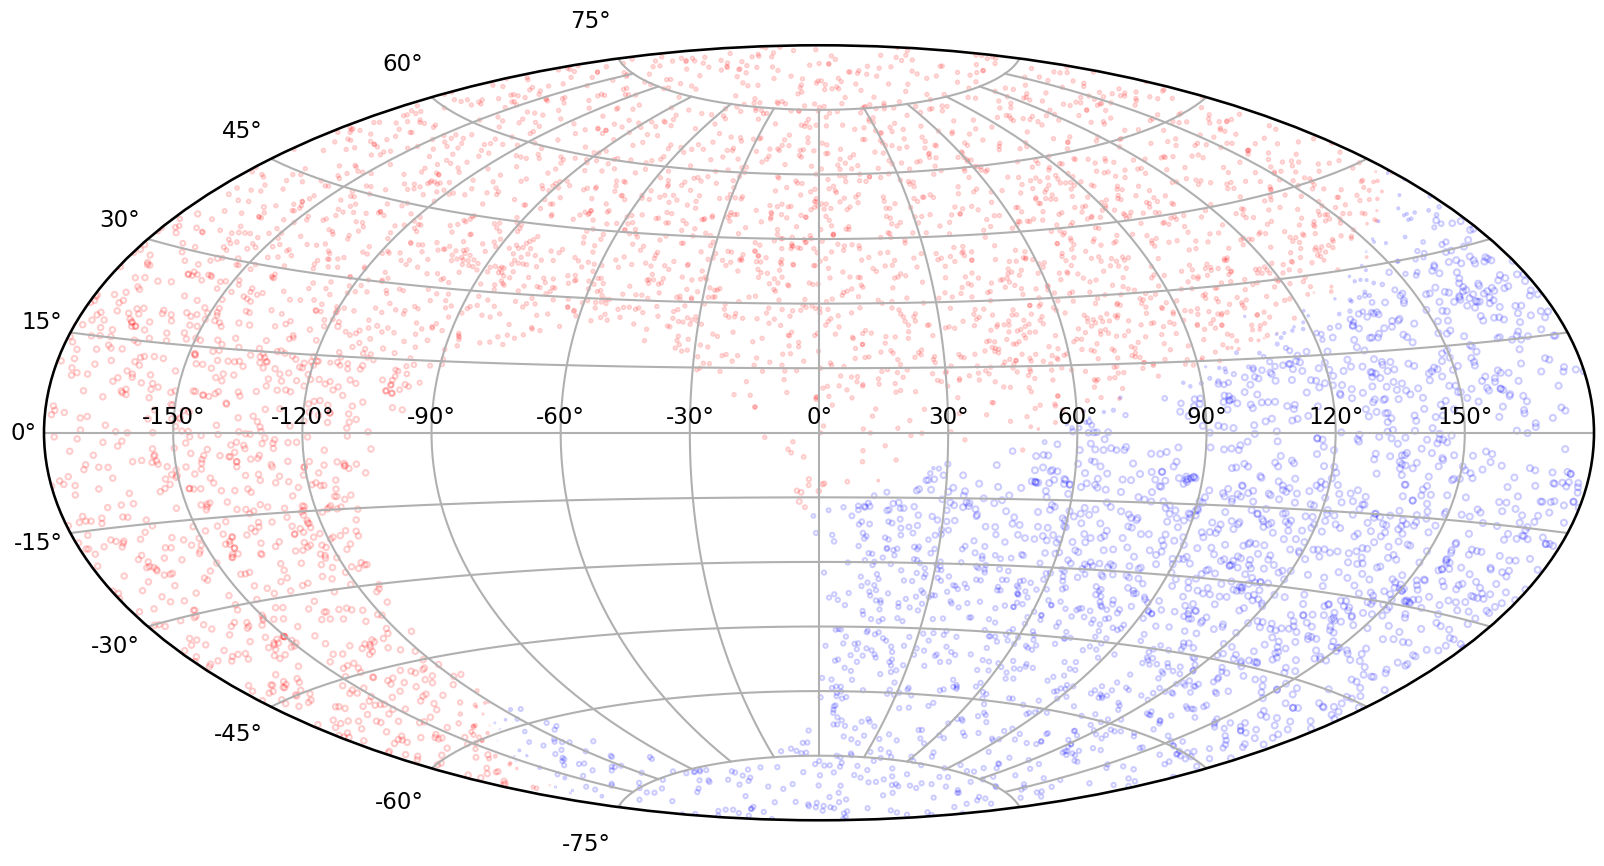

In [25]:
predcombine = xtest
predcombine['RM'] = pred

plt.figure(figsize=(20,20))
plt.subplot(111, projection='aitoff')
plt.grid(True)

gal = SkyCoord(predcombine['GLON'], predcombine['GLAT'], frame='galactic', unit=u.deg)
colour = ['r' if rm>0 else 'b' for rm in predcombine['RM']]
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian,
            facecolors = 'none',
            edgecolors = colour,
            s = np.abs(predcombine['RM']),
            alpha = 0.2)

In [26]:
xtest

GLON     GLAT        Si        Pk         m         RM
0    -168.5734 -27.4213  1.128442 -0.161313 -1.320035  15.060966
1      90.9364  49.2835 -0.184219 -0.259445 -0.663691   5.475564
2      47.0751  24.3361 -0.169907 -0.274892 -0.751346   5.475564
3      69.0888  22.3037 -0.169617 -0.305331 -0.890311   5.475564
4     -45.3138  34.7529  0.008199  1.469675  5.358859   5.475574
...        ...      ...       ...       ...       ...        ...
5627   90.3244  23.6111 -0.219348 -0.239001 -0.210449   5.475542
5628  153.9919 -25.4023 -0.287728 -0.328956 -0.107829 -18.558647
5629   44.3467 -38.3928 -0.266621 -0.017750  2.335825  -9.313743
5630  165.2742 -53.4088  0.140622  0.121270 -0.635898 -16.586590
5631    0.5416  47.2071 -0.121766 -0.092712 -0.379346   5.475564

[5632 rows x 6 columns]

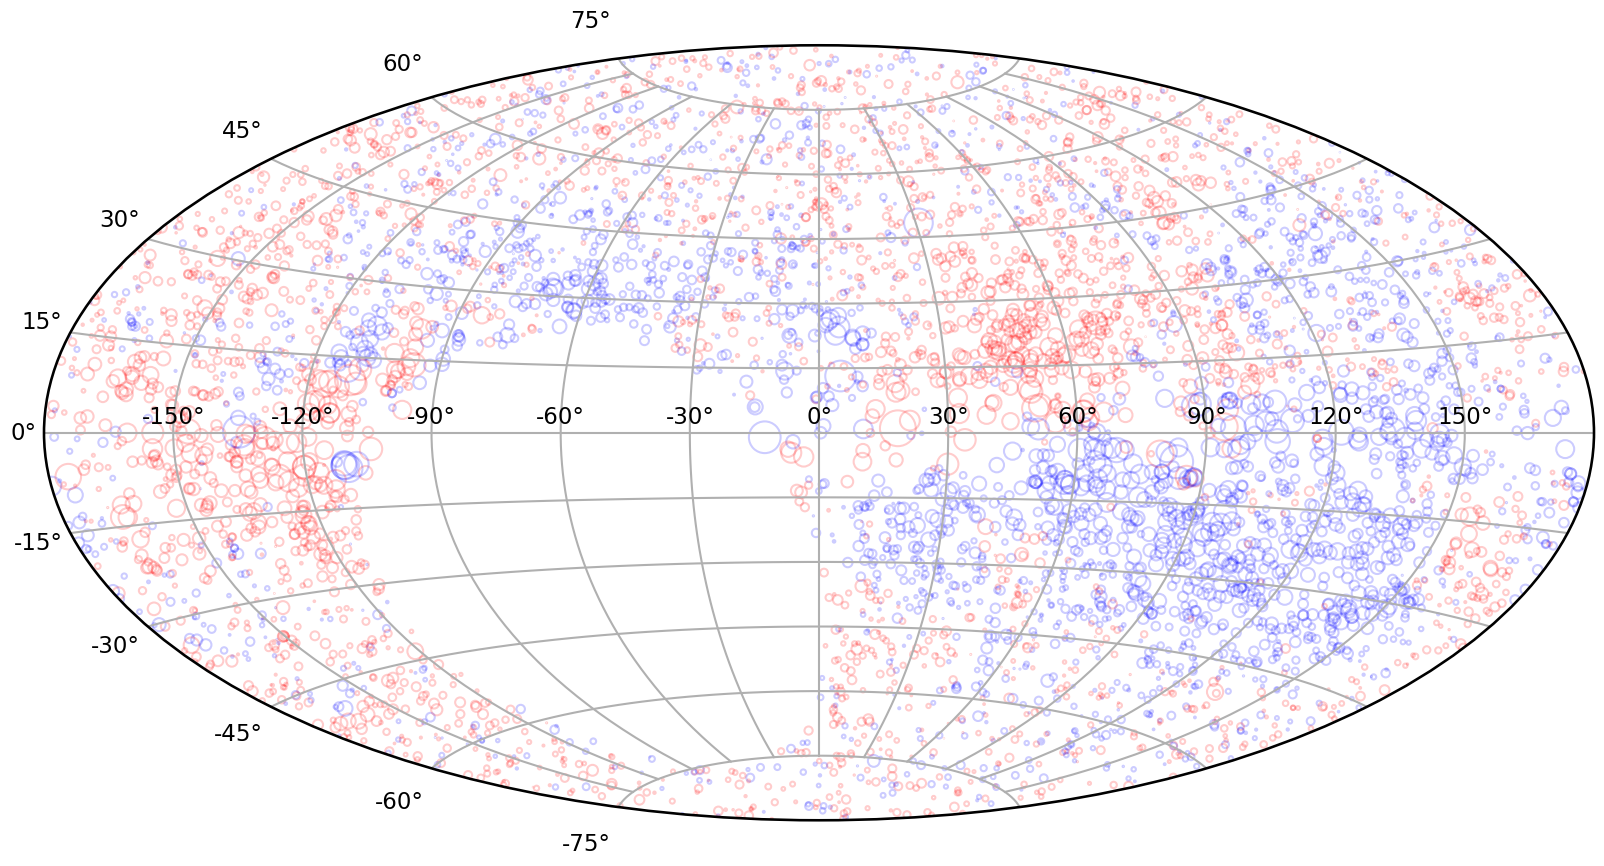

In [27]:
testcombine = xtest
testcombine['RM'] = pd.DataFrame(data = ytest, columns = ['RM'])

plt.figure(figsize=(20,20))
plt.subplot(111, projection='aitoff')
plt.grid(True)

gal = SkyCoord(testcombine['GLON'], testcombine['GLAT'], frame='galactic', unit=u.deg)
colour = ['r' if rm>0 else 'b' for rm in testcombine['RM']]
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian,
            facecolors = 'none',
            edgecolors = colour,
            s = np.abs(testcombine['RM']),
            alpha = 0.2)

# KNN

In [28]:
from sklearn.neighbors import KNeighborsRegressor

In [29]:
y = farocat['RM']
x = farocat[['GLON', 'GLAT', 'Si', 'Pk', 'm']]

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.33)

scal = StandardScaler()

scaledxtrain = pd.DataFrame(scal.fit_transform(xtrain), columns = x.columns)
scaledxtest = pd.DataFrame(scal.transform(xtest), columns = x.columns)

Text(0, 0.5, 'Error')

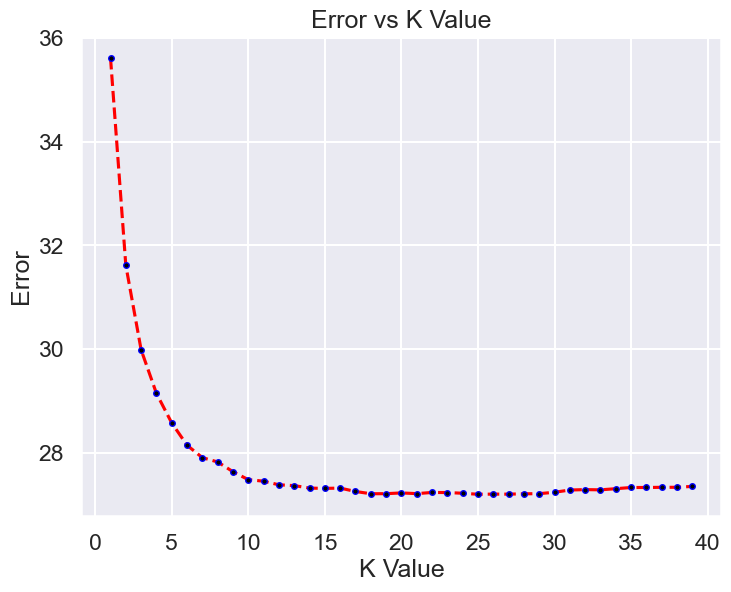

In [30]:
sb.set_style('darkgrid')
sb.set_context('talk')
K = np.arange(1,40)
error = [0]*39
for i in range(1,40):
    KNN = KNeighborsRegressor(n_neighbors=i)
    KNN.fit(scaledxtrain, ytrain)
    pred = KNN.predict(scaledxtest)
    error[i-1] = np.mean(np.abs(ytest-pred))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(K, error
        , c = 'r'
        , ls = '--'
        , marker = 'o'
        , markersize = 4
        , markerfacecolor = 'black'
        , markeredgewidth = 1
        , markeredgecolor = 'blue')
ax.set_title('Error vs K Value')
ax.set_xlabel('K Value')
ax.set_ylabel("Error")

In [39]:
KNN = KNeighborsRegressor(n_neighbors=17)

KNN.fit(scaledxtrain, ytrain)


KNeighborsRegressor(n_neighbors=17)

In [40]:
pred = KNN.predict(scaledxtest)

In [41]:
pred = pd.DataFrame(data = pred, columns = ['RM'])
predcombine = xtest[['GLON', 'GLAT']].reset_index(drop = True)
predcombine['RM'] = pred

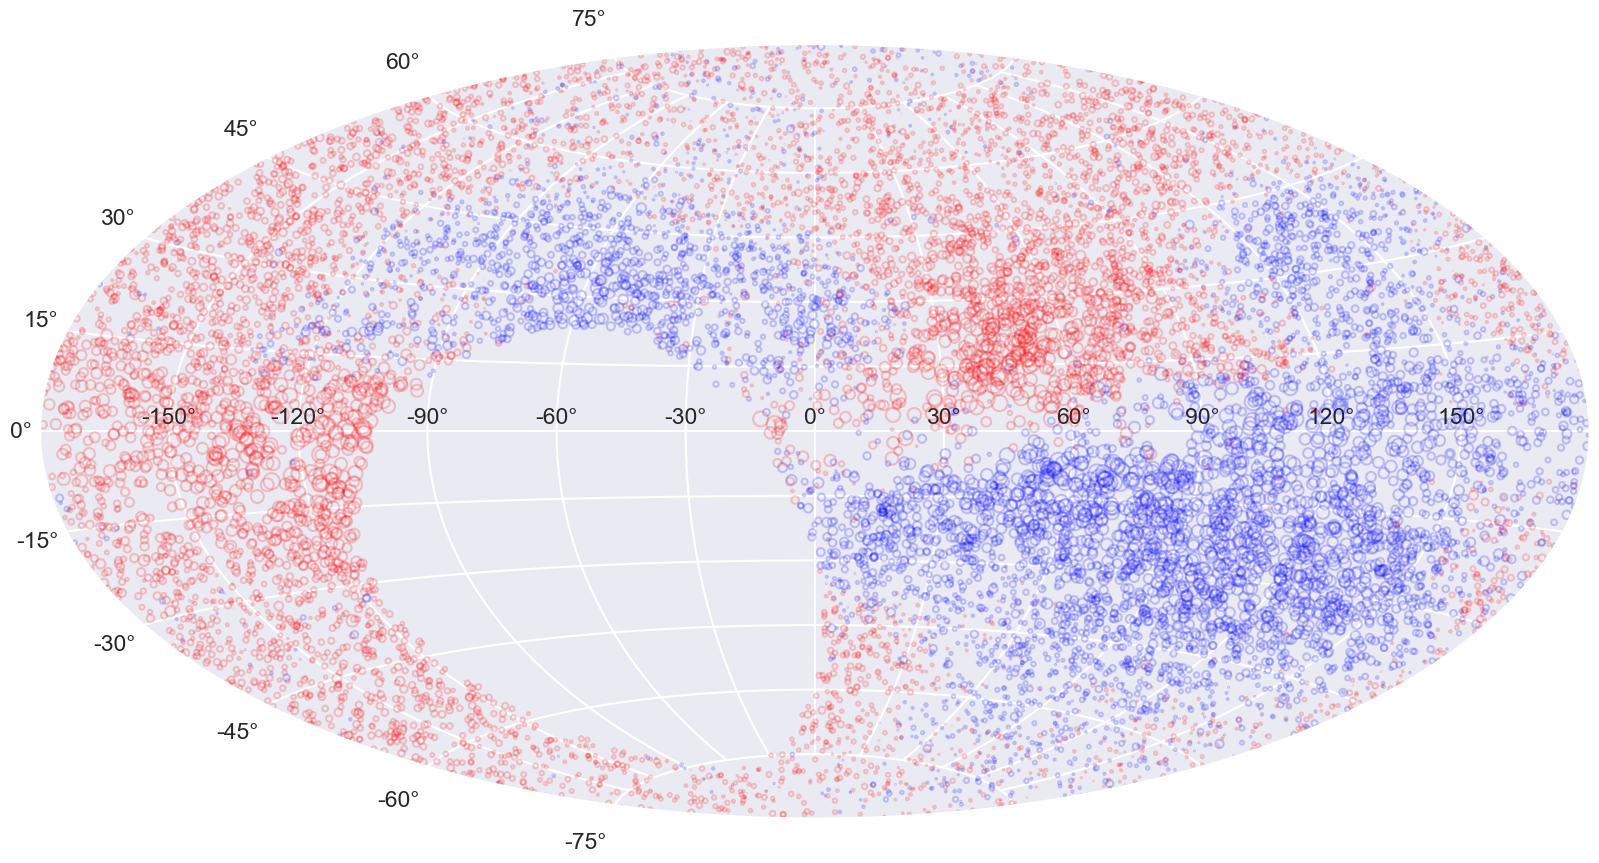

In [42]:
plt.figure(figsize=(20,20))
plt.subplot(111, projection='aitoff')
plt.grid(True)

gal = SkyCoord(predcombine['GLON'], predcombine['GLAT'], frame='galactic', unit=u.deg)
colour = ['r' if rm>0 else 'b' for rm in predcombine['RM']]
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian,
            facecolors = 'none',
            edgecolors = colour,
            s = np.abs(predcombine['RM']),
            alpha = 0.2)

In [44]:
test = pd.DataFrame(data = ytest.reset_index(drop = True), columns = ['RM'])
testcombine = xtest[['GLON', 'GLAT']].reset_index(drop = True)
testcombine['RM'] = test

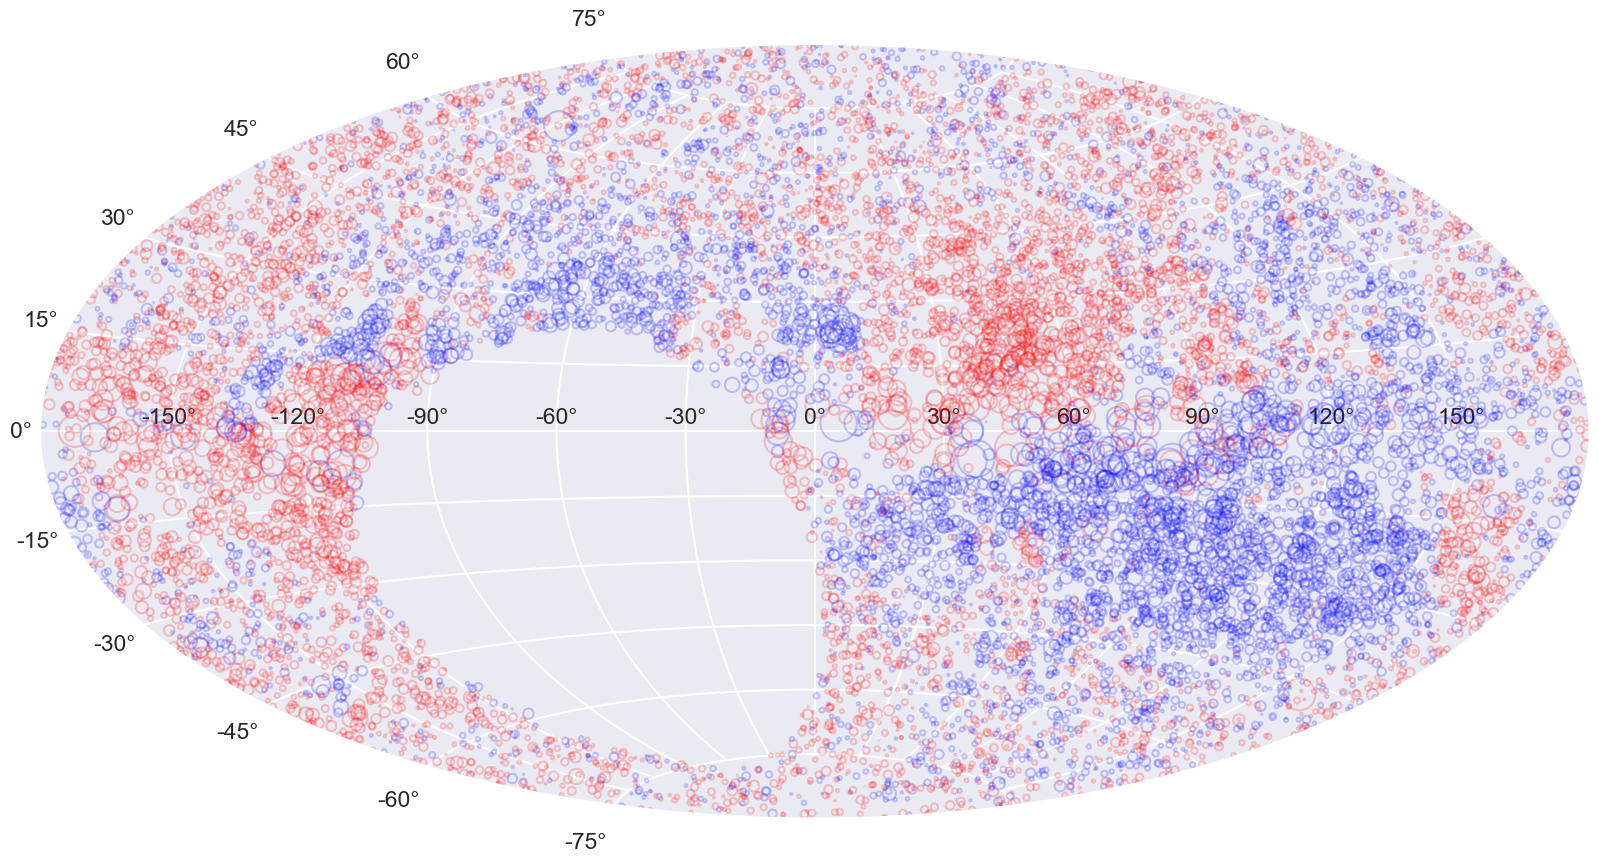

In [45]:
plt.figure(figsize=(20,20))
plt.subplot(111, projection='aitoff')
plt.grid(True)

gal = SkyCoord(testcombine['GLON'], testcombine['GLAT'], frame='galactic', unit=u.deg)
colour = ['r' if rm>0 else 'b' for rm in testcombine['RM']]
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian,
            facecolors = 'none',
            edgecolors = colour,
            s = np.abs(testcombine['RM']),
            alpha = 0.2)